<img src="images/dask_horizontal.svg" align="right" width="30%">

# Table of Contents
* [DataFrame](#DataFrame)
	* [Setup](#Setup)
	* [Load Data from CSVs and inspect the dask graph](#Load-Data-from-CSVs-and-inspect-the-dask-graph)
		* [`dask.dataframe.read_csv`](#dask.dataframe.read_csv)
		* [Exercise: Inspect dask graph](#Exercise:-Inspect-dask-graph)
	* [How does this compare to Pandas?](#How-does-this-compare-to-Pandas?)
		* [Features and Size](#Features-and-Size)
		* [Speed](#Speed)
		* [Exercise: Recall and use Pandas API](#Exercise:-Recall-and-use-Pandas-API)
		* [Exercise](#Exercise)
	* [Limitations](#Limitations)
		* [What doesn't work?](#What-doesn't-work?)
		* [What definitely works?](#What-definitely-works?)


In [1]:
# be sure to shut down other kernels running distributed clients
from dask.distributed import Client
client = Client()

# DataFrame

<img src="images/pandas_logo.png" align="right" width="40%">
In this section we use `dask.dataframe` to automatically build and execute Dask graphs which process large volumes of CSV files automatically.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

**Main Take-aways**

1.  Dask.dataframe should be familiar to Pandas users
2.  The index grows to include partitions, which are important for efficient queries

## Setup

We create artifical data.

In [2]:
from prep import accounts_csvs
accounts_csvs(3, 1000000, 500)

import os
filename = os.path.join('data', 'accounts.*.csv')

## Load Data from CSVs and inspect the Dask graph

In this section we'll use `dask.dataframe` to read in many CSV files at once and compute their total length, using a more Pandas-like interface rather than by playing with iterables and dictionaries manually.

### `dask.dataframe.read_csv`

This works just like `pandas.read_csv`, except on multiple csv files at once.

In [3]:
filename

'data/accounts.*.csv'

In [4]:
import dask.dataframe as dd
df = dd.read_csv(filename)
# load and count number of rows
%time len(df)

CPU times: user 4 ms, sys: 60 ms, total: 64 ms
Wall time: 563 ms


3000000

What happened here?
- Dask investigated the input path and found that there are three matching files 
- a set of jobs was intelligently created for each chunk - one per original CSV file in this case
- each file was loaded into a pandas dataframe, had `len()` applied to it
- the subtotals were combined to give you the final grant total.

### Exercise: Inspect Dask graph

Dask `DataFrame` copies a subset of the Pandas API.  

However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, instead they add key-value pairs to an underlying Dask graph. Recall that in the diagram below, circles are operations and rectangles are results.

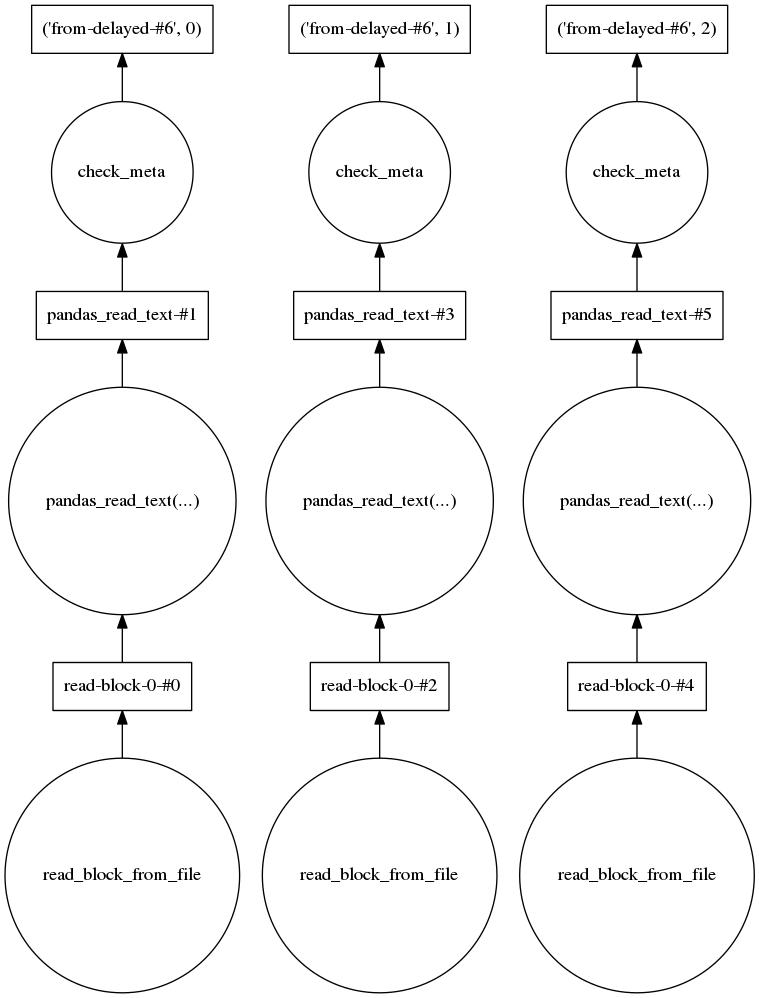

In [5]:
df.visualize()

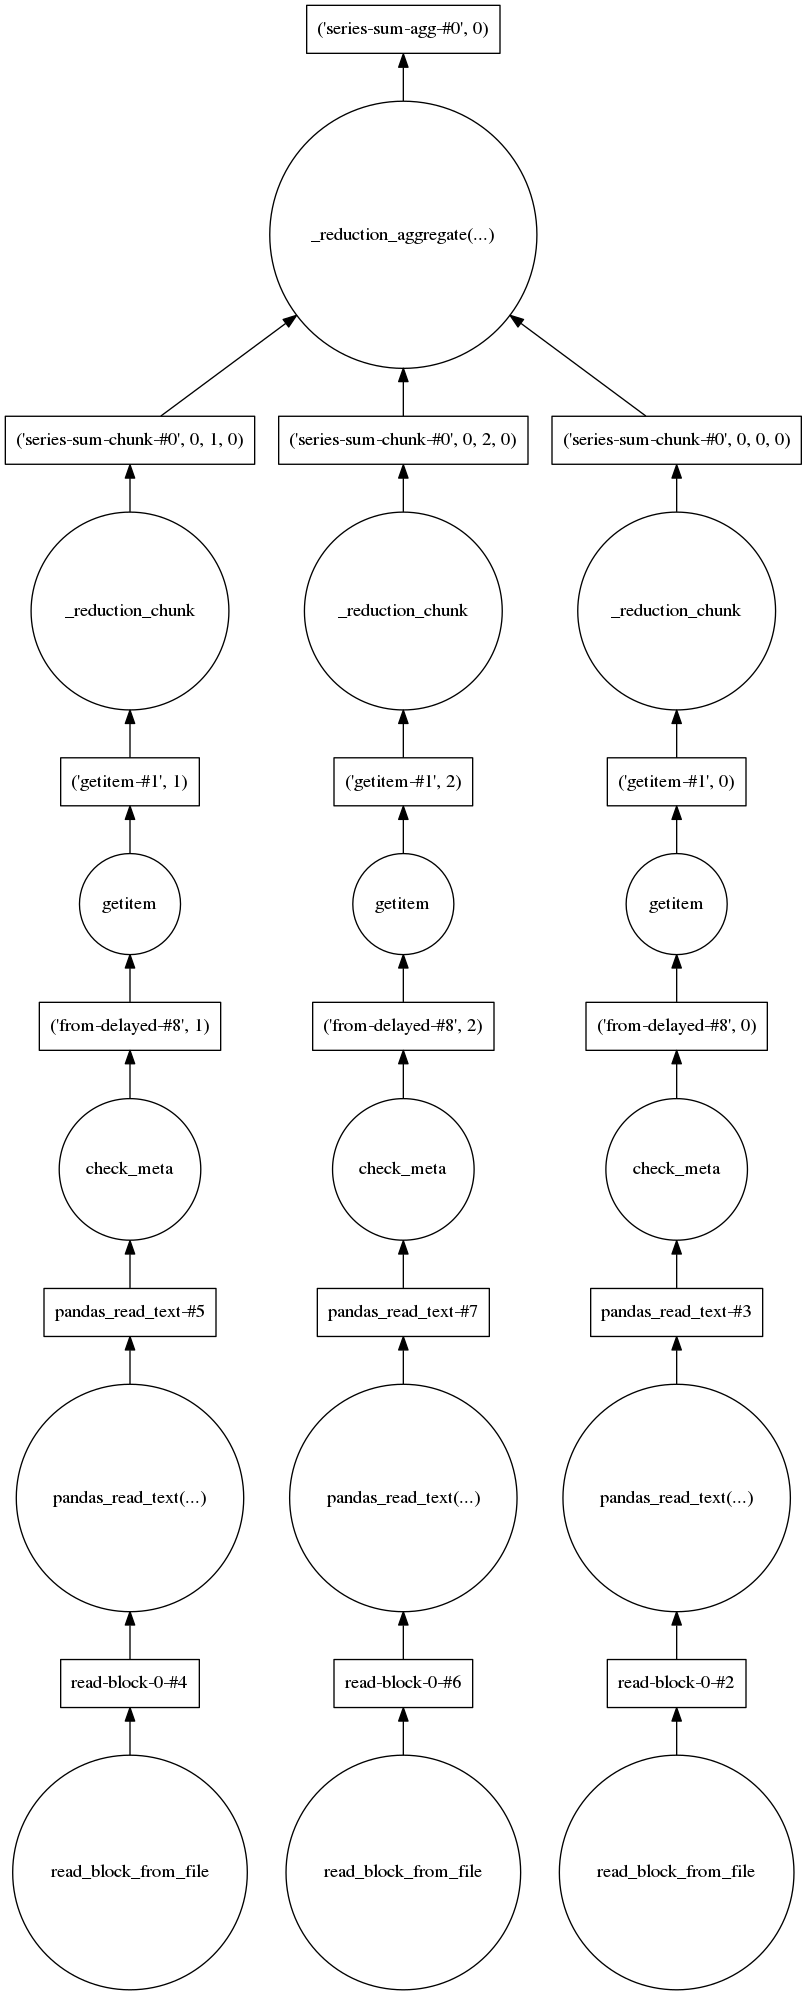

In [6]:
df.amount.sum().visualize()

Above we see graphs corresponding to a call to `dd.read_csv` and `df.amount.sum()` on the result.  

Try changing around the expression `df.amount.sum()` and see how the graph changes.  Explore a bit with the Pandas syntax that you already know.

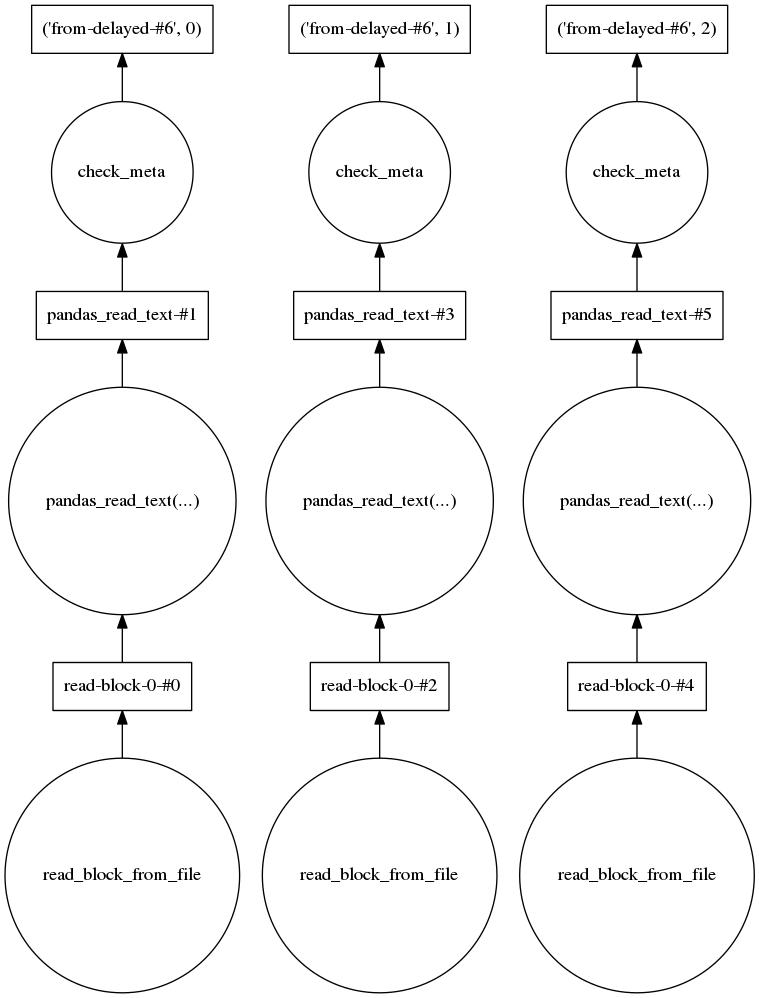

In [7]:
# try changing the expression and visualize the generated graph
df.visualize()

## How does this compare to Pandas?

### Features and Size

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 45MB on disk that expands to about 400MB in memory (the difference is caused by using `object` dtype for strings).  This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly.  Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

### Speed

Dask.dataframe operations use `pandas` operations internally.  Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL (coming to `groupby` in the next version) `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

### Exercise: Recall and use Pandas API

If you are already familiar with the Pandas API then you should have a firm grasp on how to use `dask.dataframe`.  There are a couple of small changes.

As noted above, computations on Dask `DataFrame` objects don't perform work, instead they build up a Dask graph.  We can evaluate this Dask graph at any time using the `.compute()` method.

In [8]:
result = df.amount.mean()  # create lazily evaluated result
result

dd.Scalar<series-..., dtype=float64>

In [9]:
result.compute()           # perform actual computation

946.3402513333333

**Aside:** Calling `compute()` caused the execution of the whole graph, returned the value, and then freed up the associated resources. This is normal execution, which leaved all memory available for whatever is next. If we had called `client.compute(result)`, this would have given us a *future*, and instantly returned - the only advantage being that we can do other work while the cluster performs its actions, and we keep a handle to the result (which is cached while the future lives). In order to avoid going through the CSV load every time, we can *persist* the loaded dataframe into the cluster memory - if the cluster has enough memory. This is a very typical step for load-once, query-often data:
```python
df = client.persist(df)
```

Try the following exercises

1.  Use the `head()` method to get the first ten rows
2.  Use the `drop_duplicates()` method to find all of the distinct names
3.  Use selections `df[...]` to find how many positive and negative amounts there are
4.  Use groupby `df.groupby(df.A).B.func()` to get the average amount per user ID
5.  Sort the result to (4) by amount, find the names of the top 10 

This section should be easy if you are familiar with Pandas.  If you aren't then that's ok too.  You may find the [pandas documenation](http://pandas.pydata.org/) a useful read in the future.  Don't worry, future sections in this tutorial will not depend on this knowledge.

In [10]:
# 1. Use the `head()` method to get the first ten rows
#    Note, head computes by default, this is the only operation that doesn't need an explicit call to .compute()
df.head()

,id,names,amount
0,365,Norbert,-527
1,391,Tim,1272
2,228,Ursula,1440
3,495,Quinn,378
4,20,Xavier,3510


In [11]:
# 2. Use the `drop_duplicates()` method to find all of the distinct names
df.drop_duplicates()

,id,names,amount
npartitions=1,,,
,int64,object,int64
,...,...,...


In [27]:
# 3. Use selections `df[...]` to find how many positive and negative amounts there are
len(df[df["amount"] > 0])

2474784

In [28]:
# 3. Use selections `df[...]` to find how many positive and negative amounts there are
len(df[df["amount"] < 0])

514080

In [29]:
# 4. Use groupby `df.groupby(df.A).B.func()` to get the average amount per user ID 
df.groupby(df.names).amount.mean().compute()

names
Alice       1386.467526
Bob          857.519302
Charlie     1145.520294
Dan         1037.645025
Edith       1686.788093
Frank       1458.075612
George      1026.172520
Hannah       637.560444
Ingrid       496.022855
Jerry        585.920564
Kevin        416.306429
Laura        422.279700
Michael      866.425276
Norbert      925.516955
Oliver      1300.859304
Patricia    1664.412768
Quinn        541.574351
Ray          798.438070
Sarah        479.818061
Tim          743.620207
Ursula       887.725333
Victor      1651.732215
Wendy       1369.675430
Xavier       481.314516
Yvonne       430.274846
Zelda       1193.146973
Name: amount, dtype: float64

In [31]:
# 5. Combine your answers to 3 and 4 to compute the average withdrawal (negative amount) per name
df_negative = df[df.amount < 0]
df_negative.groupby(df_negative.names).amount.mean().compute()

names
Alice        -90.307725
Bob         -236.948897
Charlie     -683.511726
Dan        -1079.106667
Edith       -490.541032
Frank       -983.397148
George       -55.648891
Hannah      -507.860820
Ingrid       -66.329660
Jerry       -133.122491
Kevin        -92.686888
Laura       -363.751790
Michael     -122.808828
Norbert     -707.016814
Oliver      -849.459159
Patricia    -207.816540
Quinn       -736.229706
Ray         -652.182856
Sarah        -76.870163
Tim          -22.350342
Ursula      -346.377339
Victor      -211.359200
Wendy        -79.804040
Xavier     -1227.617245
Yvonne      -121.310853
Zelda       -293.388563
Name: amount, dtype: float64

<img src="images/dask-dataframe.svg" align="right" width="40%">

Divisions and the Index
---------------------------

The Pandas index associates a value to each record/row of your data.  Operations that align with the index, like `loc` can be a bit faster as a result.

In `dask.dataframe` this index becomes even more important.  Recall that one Dask `DataFrame` consists of several Pandas `DataFrame`s.  These dataframes are separated along the index by value.  For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas `DataFrames` on demand.

Partitioning your data can greatly improve efficiency.  Operations like `loc`, `groupby`, and `merge/join` along the index are *much more efficient* than operations along other columns.  You can see how your dataset is partitioned with the `.divisions` attribute.  Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default.  In these cases the values for `.divisions` will be `None.`

In [32]:
df = dd.read_csv(filename)
df.divisions

(None, None, None, None)

However if we set the index to some new column then Dask will divide our data roughly evenly along that column and create new divisions for us.  Warning, `set_index` triggers immediate computation.

In [33]:
df2 = df.set_index('names')
df2.divisions

('Alice', 'Frank', 'Quinn', 'Zelda')

We see here the minimum and maximum values ("Alice" and "Zelda") as well as two intermediate values that separate our data well.  This dataset has three partitions.

**Aside:** immediately after expensive operations such as set_index would also be a good time to use `client.persist` if the cluster has enough memory.

In [34]:
df2.npartitions

3

In [35]:
df2.head()

,id,amount
names,,
Alice,98,4725
Alice,29,1463
Alice,177,3419
Alice,270,85
Alice,388,1253


Operations like `loc` only need to load the relevant partitions

In [36]:
df2.loc['Edith']

,id,amount
npartitions=1,,
Edith,int64,int64
Edith,...,...


In [37]:
df2.loc['Edith'].compute()

,id,amount
names,,
Edith,22,7
Edith,354,672
Edith,420,1028
Edith,192,6355
Edith,171,1057
Edith,404,-1887
Edith,231,1170
Edith,354,557
Edith,192,6572


### Exercise

Make a new dataframe that sets the index to the `id` column.  Use `loc` to collect the records with the 100th id.

In [38]:
df2 = df.set_index("id")

In [39]:
print(df2.loc[100])

Dask DataFrame Structure:
                names amount
npartitions=1               
100            object  int64
100               ...    ...
Dask Name: loc, 46 tasks


## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial inter-process communication and may write out to disk.

Finally, `dask.dataframe` is quite new and non-trivial bugs are frequently reported (and quickly fixed).

### What definitely works?

* Trivially parallelizable operations (fast):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Cleverly parallelizable operations (also fast):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Operations requiring a shuffle (slow-ish, unless on index)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Ingest operations
    *  CSVs: ``dd.read_csv``
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  From any set of functions creating sub dataframes via ``dd.from_delayed``.
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``